# 0. Import libs

In [1]:
import pandas as pd
import numpy as np
import re
import math
import collections as co
import  scipy
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import pysubgroup as ps
from yellowbrick.features import Rank2D,RFECV


In [2]:
# Только для красоты, в реальной жизни Warnings могут помочь найти ошибку в коде
import warnings
warnings.filterwarnings('ignore')

In [3]:
def write_answer(file_name,answer):
    file = open('./results/'+str(file_name) + '.txt','w') 
    file.write(str(answer) ) 
    file.close() 
write_answer('self0','example_answer')
#к каждой задаче задаче записывайте ответ в виде self{X} , где {X} это номер задачи в заголовке

# 1. load data

In [4]:
client_sms = pd.read_csv('./data/clientSMS_v2.csv', sep='\t', names = ['text', 'sentiment'])

negative_tweet = pd.read_csv('./data/negative.csv', sep=';', usecols=[3], names=['text'])
negative_tweet['sentiment'] = 2

positive_tweet = pd.read_csv('./data/positive.csv', sep=';', usecols=[3], names=['text'])
positive_tweet['sentiment'] = 1

kaggle_sentiment = pd.read_json('./data/kaggle_sentiment.json', encoding='UTF-8')
kaggle_sentiment = kaggle_sentiment[['text','sentiment']]

In [5]:
df = pd.concat([kaggle_sentiment, client_sms, negative_tweet, positive_tweet], axis=0, ignore_index=True)

# 2. preproc

In [6]:
df['text'] = df['text'].str.replace("\n"," ")

df['sentiment'] = df['sentiment'].astype(str).replace("negative",2)
df['sentiment'] = df['sentiment'].astype(str).replace("positive",1)
df['sentiment'] = df['sentiment'].astype(str).replace("neutral",0)

df['sentiment'] = df['sentiment'].astype(int)

In [7]:
#self1
#удалите все ники с учетом первого символа @
#превратите двойные пробелы в одинарные
#запишите ответ первого задания как количество всех симфолов в тексте в поле "text" после преобразований
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.replace.html
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.len.html
regex_pat = re.compile(r'@\S+', flags=re.IGNORECASE)
df['text'] = df['text'].str.replace(regex_pat, '')
df['text'] = df['text'].str.replace('  ', ' ')

write_answer('self1',df['text'].str.len().sum())

In [8]:
#self2
#превратите все числа в фразу "число"
#запишите ответ второго задания как количество всех симфолов в тексте в поле "text" после преобразования
regex_pat = re.compile(r'\d+', flags=re.IGNORECASE)
df['text'] = df['text'].str.replace(regex_pat, 'число')

write_answer('self2',df['text'].str.len().sum())

In [9]:
df['text'] = df['text'].str.lower()

In [10]:
#self3
#предлог "не" имеет противоположный эффект к слову, мы не можем не учитывать это, давайте соединим не и слово с помощью замены "не " на "не_"
#важно - учтите, что есть слова, которые заканчиваются на "не", не ошибитесь
#ответом на третье задание будет количество "не_" в текстах колонки text
regex_pat = re.compile(r'\Wне\s', flags=re.IGNORECASE)
df['text'] = df['text'].str.replace(regex_pat, ' не_')
regex_pat = re.compile(r'^не\s', flags=re.IGNORECASE)
df['text'] = df['text'].str.replace(regex_pat, 'не_')

write_answer('self3',df['text'].str.count('не_').sum())

In [11]:
#перемешаем наш датасет, т.к. он состоит из разных выборок данных
df = df.sample(frac=1 ).reset_index(drop = True)[:]

# 3. factor generator

In [12]:
df['cnt_!'] = df['text'].str.count('\!')
df['cnt_?'] = df['text'].str.count('\?')
df['cnt_.'] = df['text'].str.count('\.')

In [13]:
#self4
#добавим фактор количество слов в предложении
#давайте посчитаем среднее целое округленное до ближайшего значения вверх количество слов в сообщениях как ответ к четвертому заданию
df['cnt_words'] = df['text'].str.split('\W+').apply(lambda x: len(x))

write_answer('self4',math.ceil(df['cnt_words'].mean()))

(25.194160064778384, 35.10315747477232)


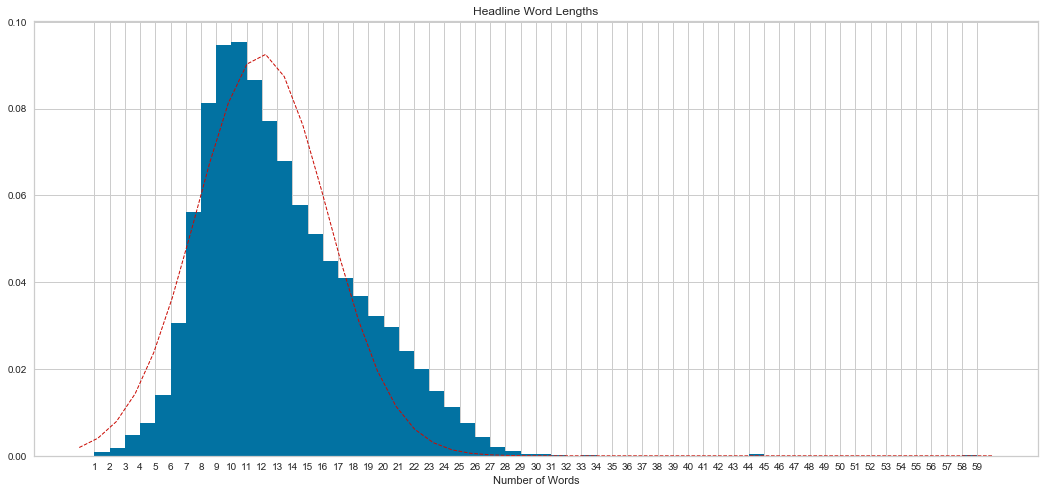

In [14]:
#self5
#давайте визуализируем гистаграмму количества слов в тексте https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html

word_counts = df['cnt_words']
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,60), normed=1)
ax.set_title('Headline Word Lengths')
ax.set_xticks(range(1,60))
ax.set_xlabel('Number of Words')
#нарисуем поверх нее плотность нормального распределения с матожиданием в медиане и дисперсией 1/7 от среднего количества слов в предложении
y = mlab.normpdf( np.linspace(0,60,50), np.median(word_counts), np.mean(word_counts) / 7 )
l = ax.plot(np.linspace(0,60,50), y, 'r--', linewidth=1)
#давайте посчитаем 75% доверительный интервал для количества сообщений по заданнорму нормальному распределенению
conf_interval = scipy.stats.norm.interval(0.75, loc=word_counts.mean(), scale = np.mean(word_counts) / 7)
print(conf_interval)

#ответом на пятое задание есть массив левая и правая граница доверительного интервала округленная до 2 знака после запятой, записанная через запятую.
write_answer('self5',[np.round(conf_interval[0],2) , np.round(conf_interval[1],2)])


In [15]:
#self6
#оставим в нашем датасете только те сообщения, которые охватываются нашим доверительным интервалом
#, чтобы модель не переобучалась на слишком длинных сообщениях
print(df.shape[0])

df = df[(df.cnt_words < conf_interval[1])][:]

print(df.shape[0])

#ответом на 6 задание будет новое значение количества строк в нашем датафрейме
write_answer('self6',df.shape[0])

238997
230880


# 4. load hard dataset

In [16]:
#1 - смайлики
#2 - знаки
#3 - уменьшительно ласкательные суффиксы
#4 - явные слова
#5 - матерные слова
#6 - увеличение и уменьшение
#7 - стандарты автоответов
#8 - жизнь хорошо, смерть плохо
#9 - друг хорошо, враг плохо
#10 - ужас, страх это плохо
#11 - троеточие или две точки чаще плохо, больше 3 точек чаще хорошо
#12 - стандарты магазинов это позитивчик
#13 - когда скучают это хорошо
#14 - приветствие это хорошо
#15 - тянущиеся гласные это хорошо
#16 - эмоции
#17 - срочность это плохо, отрицание срочности хорошо
#18 - количество слов в смс
#19 - предлог "бы" чаще плохо
#20 - предлог "не" чаще плохо
#21 - отсутствие "никто" чаще плохо
#22 - интерес это хорошо
#23 - нужен это хорошо
#24 - действие это хорошо
#25 - отсутствие действия это плохо
#26 - суффикс повелительный это плохо
#27 - быстрое действие это хорошо перед нейтральным словом это плохо
#28 - согласие это хорошо
#29 - наказание это плохо
#30 - благодарность это хорошо
#31 - жаргон это плохо
#32 - отдых это хорошо
#33 - пожелания это хорошо
#34 - мольба это хорошо
#35 - радостные слова
#36 - Уменьшительные имена это хорошо
#37 - скука это хорошо
#38 - волнение это плохо
#39 - предлог некогда плохой
#40 - наименование животным это хорошо
#41 - отказ это плохо
#42 - сочетание знаков !? или ?! это плохо
#43 - обязательства это плохо
#44 - злось это плохо
#45 - добрые пожелания это хорошо
#46 - оскорбления это плохо
#47 - начало предложения с "И" или "АУ" это плохо
#48 - траты это плохо
#49 - обман это плохо
#50 - свобода это хорошо
#51 - упоминание стран курорта это хорошо
#52 - комбинация ахахаха это хорошо
#53 - не это плохо
#53 - ничего перед не убирает отрицание не перепи
#53 - или перед не и нет убирает плохое состояние
#54 - радость это хорошо
#55 - когда что-либо нравится это хорошо

In [17]:
df = pd.read_csv('./data/full_df.csv')

# 5. model

In [28]:
#self7
#subgroup discovery
#исследуем наши данные
#давайте выделим таргет позитивных сообщений и посмотрим что на них влияет
df_subd = df.sample(3000)


#выделете таргет sentiment положительный
target = ps.NominalTarget(target_selector=ps.NominalSelector('sentiment', 1))

#задайте область поиска весь датафрейм игнорируя поле sentiment
searchSpace = ps.create_selectors(df_subd, ignore=['sentiment'])

#задайте задачу поиска SubgroupDiscoveryTask влияния на таргет target в поле поиска searchSpace
#найдите 3 подгруп
#по глубине 2 предикатами
#функцию качества задайте на базе Chi2 ps.StandardQF(1)
task = ps.SubgroupDiscoveryTask(
    df_subd,
    target=target,
    search_space=searchSpace,
    result_set_size = 3, # на выход получаем 5 подгрупп
    depth = 2, # Каждая подгруппа описывается не более чем 3 предикатами какое колво вопросов комбинируем максимально для поиска групп
    qf = ps.StandardQF(1) # Функция качества на базе Chi2 - 1 это степень за которую отвечает возводиться размер подгруппы, чем больше тем больше степень для поиска подгруппы, тем больше подгруппу ищем
)


result = ps.BeamSearch().execute(task)

#выведете результаты
i=0
for (q,sg) in result:
    print(str(q) + ":\t" + str(sg.subgroup_description))
    if i ==0:
        q_ans = q
        sg_ans = str(sg.subgroup_description)
    i +=1
    
#сохраните значение q и описание подгруппы первой самой большой как ответ к заданию 7 в формате массива [0.123 , "dada"]
write_answer('self7',[q_ans , sg_ans])


0.017463888888888883:	cnt_.: [1:2[ AND rule_41=0.0
0.016809444444444443:	cnt_.: [1:2[ AND rule_28=0.0
0.01647388888888887:	cnt_.: [1:2[ AND rule_3=0.0


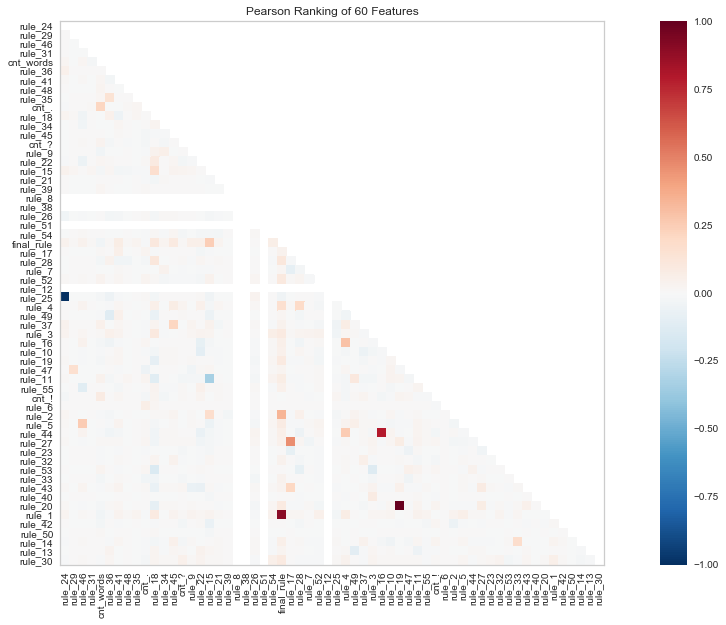

In [41]:
# постройте матрицу корреляций факторов Rank2D через библиотеку yellowbrick
#постройте то количество, которое будет удобно выводиться у вас на компьютере
names = list(set(df.columns) - set(['text','sentiment']) )
_, ax = plt.subplots(figsize=(20,10))
rank = Rank2D(ax=ax,features=names,algorithm='pearson')
rank.fit(df_subd[names],df_subd['sentiment'])
rank.transform(df_subd[names])
rank.poof()

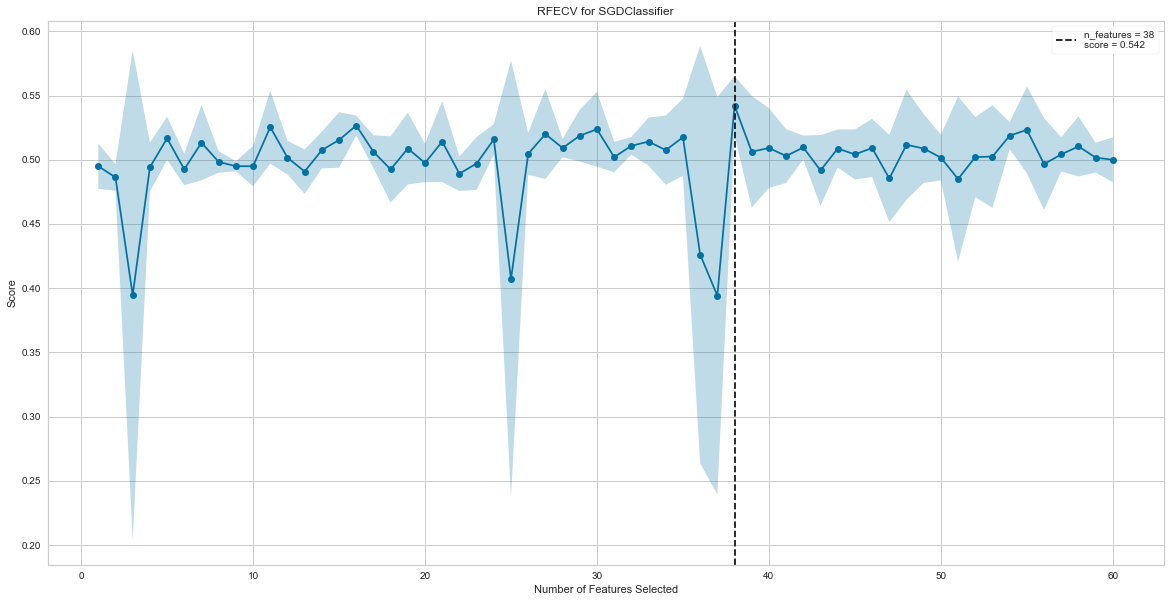

In [44]:
#сделаем простую модель и постараемся выбрать лучшие факторы для нее через RFECV
from sklearn import   linear_model, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier as SGD
from sklearn.model_selection import ShuffleSplit, train_test_split , StratifiedShuffleSplit

classifier = SGD()

cv=ShuffleSplit(n_splits=4,train_size=0.8,test_size=0.2,random_state= 42)

_, ax = plt.subplots(figsize=(20,10))
rfe = RFECV(classifier,cv=cv,step=10)
rfe.fit(df_subd[names],df_subd['sentiment'])
rfe.poof()

In [51]:
#self8
#создадим параметры  рангов полей на нашем датасете df_subd[names]
params = {
    'parameters': list(df_subd[names]),
    'ranking':list(rfe.ranking_)
}

#сделайтее список из факторов третьего ранга
par = pd.DataFrame(data=params)
best_params = list(par[par['ranking']==3]['parameters'])


#ответом на 8 задание будет массив факторов третьего ранга
write_answer('self8',best_params)

['rule_29',
 'rule_31',
 'rule_18',
 'rule_26',
 'rule_17',
 'rule_49',
 'rule_37',
 'rule_16',
 'rule_40',
 'rule_14']